*Importing Libraries*

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import copy
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform, cdist
import networkx as nx
from networkx.algorithms import tree

*Reading Dataset*

In [106]:
X = pd.read_csv('../cleaned_dataset/merged_dataset.csv')
Y = pd.read_csv('../dataset/actual.csv')

print(X.shape)
# Remove first column
nodes = np.delete(X.values, 0, 1)
print(nodes)
X.head()


(72, 7130)
[[-214 -153  -58 ...   36  191  -37]
 [-139  -73   -1 ...   11   76  -14]
 [ -76  -49 -307 ...   41  228  -41]
 ...
 [ -55  -44   12 ...   -4  176   40]
 [ -59 -114   23 ...    0   74  -12]
 [-131 -126  -50 ...   34  237   -2]]


,Patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,1,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
1,2,-139,-73,-1,283,-264,-400,-330,-168,101,...,169,837,-36,442,-17,782,295,11,76,-14
2,3,-76,-49,-307,309,-376,-650,33,-367,206,...,315,1199,33,168,52,1138,777,41,228,-41
3,4,-135,-114,265,12,-419,-585,158,-253,49,...,240,835,218,174,-110,627,170,-50,126,-91
4,5,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25


In [107]:
print(Y['cancer'].value_counts())
Y.head()

ALL    47
AML    25
Name: cancer, dtype: int64


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


*Determining number of clusters using elbow method*

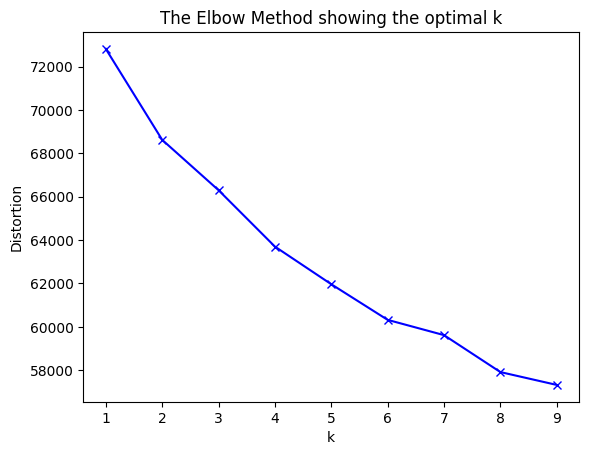

In [108]:
# Determine the number of clusters using the elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(nodes)
    kmeanModel.fit(nodes)
    distortions.append(sum(np.min(cdist(nodes, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / nodes.shape[0])

# Plot
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

*K-means Clustering*

In [109]:
def doKmeans(X, nclust):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [110]:
start=time.time()
clust_labels, cent = doKmeans(nodes, 2)
kmeans = pd.DataFrame(clust_labels)
end=time.time()
print("Execution time:",end-start)
print(kmeans[0].value_counts())
score=silhouette_score(nodes, clust_labels,metric='euclidean')
print(score)

Execution time: 0.11606717109680176
1    49
0    23
Name: 0, dtype: int64
0.12991924956896217


*Computing Adjacency Matrix*

In [111]:
G = nx.Graph()
dist_matrix = squareform(pdist(nodes))

# Create a Complete Graph
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        G.add_edge(i, j, weight=dist_matrix[i][j])

# Print adjacency matrix
np.set_printoptions(precision=3)
print(nx.adjacency_matrix(G).todense())

[[     0.     84238.563  88486.177 ...  83298.155  70427.452  60936.541]
 [ 84238.563      0.     84387.974 ... 102642.753  82742.1    83679.759]
 [ 88486.177  84387.974      0.    ... 102304.189 103878.755  94722.794]
 ...
 [ 83298.155 102642.753 102304.189 ...      0.     82128.374  72886.682]
 [ 70427.452  82742.1   103878.755 ...  82128.374      0.     53675.325]
 [ 60936.541  83679.759  94722.794 ...  72886.682  53675.325      0.   ]]


*Finding MST*

Number of edges in MST:  71
Number of nodes in MST:  72


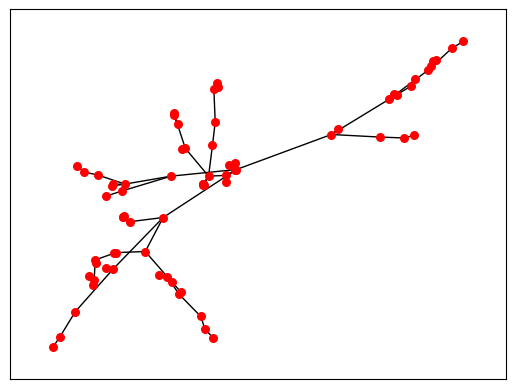

In [112]:
mst = tree.minimum_spanning_tree(G, algorithm="kruskal")
print("Number of edges in MST: ", mst.size())
print("Number of nodes in MST: ", mst.order())

# Visualize the MST
nx.draw_networkx(mst, node_size=30, node_color='red', with_labels=False)
plt.show()

*Clustering by removing Longest Edge*

In [113]:

sorted_edges=sorted(mst.edges(data=True), key=lambda t: t[2].get('weight',1))
n = len(nodes)
visited = set()
adjMatrix =[[-1 for i in range(n)] for i in range(n)]

In [114]:
def traverse(start,result,adjMatrix):
    result.append(start)
    visited.add(start)
    for i in range(n):
        if(i not in visited and adjMatrix[start][i]!=-1):
            traverse(i,result,adjMatrix)

In [115]:
# removing k longest edges
k = 2
clusters=[]
e=len(sorted_edges)
for i in range(e-k):
    adjMatrix[sorted_edges[i][0]][sorted_edges[i][1]] = sorted_edges[i][2]['weight']
    adjMatrix[sorted_edges[i][1]][sorted_edges[i][0]] = sorted_edges[i][2]['weight']
for i in range(n):
    if i not in visited:
        result=[]
        traverse(i,result,adjMatrix)
        clusters.append(result) 
end=time.time()
print("Execution time:",end-start)
# Printing the clusters
print("Clusters:")
for i in range(len(clusters)):
    print(clusters[i])

Execution time: 0.5666470527648926
Clusters:
[0, 3, 6, 13, 1, 16, 10, 2, 8, 9, 5, 22, 23, 4, 14, 17, 67, 15, 18, 39, 40, 11, 24, 28, 56, 53, 59, 64, 51, 54, 42, 55, 34, 46, 65, 58, 26, 48, 33, 27, 31, 32, 36, 37, 49, 29, 35, 30, 62, 61, 50, 60, 57, 52, 7, 71, 12, 41, 47, 19, 68, 21, 25, 44, 45, 43, 69, 38, 66, 70]
[20]
[63]


*Clustering using MSDR*

In [116]:
edgesRemoved = []

In [117]:
def stdevMST(G):
    wts=[]
    for e in G.edges(data=True):
        wts.append(e[2]['weight'])
    return statistics.stdev(wts)
def stdevComponents(comp):
    n=0
    d=0
    for c in comp:
        no_of_edges=c.number_of_edges()
        if no_of_edges>=2:
            n=n+no_of_edges*stdevMST(c)
        d=d+no_of_edges
    return n/d

def MSDR(T_0):
    _delStdv = [0.0]
    S_k = copy.deepcopy(T_0)
    G = copy.deepcopy(T_0)
    _stdevT0 = stdevMST(G)
    _stdevSk = 0
    epsilon = 0.000001
    subgraphs = []
    i = 0
    Flag = True
    while Flag:
        i += 1
        _delStdv.append(-1e9)
        edgeSelected = None
        for e in G.edges():
            eWeight = G[e[0]][e[1]]['weight']
            G.remove_edge(e[0], e[1])
            subgraphs = [copy.deepcopy(G.subgraph(c)) for c in nx.connected_components(G)]
            _stdevSk = stdevComponents(subgraphs)
            if _delStdv[i] < _stdevSk - _stdevT0:
                _delStdv[i] = _stdevSk - _stdevT0
                edgeSelected = e
            G.add_edge(e[0], e[1], weight = eWeight)
        G.remove_edge(edgeSelected[0], edgeSelected[1])
        edgesRemoved.append(edgeSelected)
        if abs(_delStdv[i] - _delStdv[i-1]) < abs(epsilon * (_delStdv[i] +1)) :
            Flag = False
        if i == 2:
            Flag = False
    return G,_delStdv

In [118]:
start=time.time()
G,s=MSDR(mst)
adjMatrix2 =[[-1 for i in range(n)] for i in range(n)]
e=len(sorted_edges)
for i in range(e):
    adjMatrix2[sorted_edges[i][0]][sorted_edges[i][1]] = sorted_edges[i][2]['weight']
    adjMatrix2[sorted_edges[i][1]][sorted_edges[i][0]] = sorted_edges[i][2]['weight']

for edge in edgesRemoved:
    adjMatrix2[edge[0]][edge[1]]=-1
clusters=[]
visited=set()
for i in range(n):
    if i not in visited:
        result=[]
        traverse(i,result,adjMatrix2)
        clusters.append(result) 
print(len(clusters))
for i in range(len(clusters)):
    print(clusters[i])
end=time.time()
print("Execution time:",end-start)

3
[0, 3, 13, 1, 16, 10, 2, 8, 9, 5, 22, 23, 4, 14, 17, 67, 15, 18, 39, 63, 20, 40, 11, 24, 28, 56, 53, 59, 64, 51, 54, 42, 55, 34, 46, 65, 58, 26, 48, 33, 27, 31, 32, 36, 37, 49, 29, 35, 30, 62, 61, 50, 60, 57, 52, 7, 71, 12, 47, 19, 68, 21, 25, 44, 45, 43, 69, 38, 66, 70]
[6]
[41]
Execution time: 0.5540299415588379
